# OVERLAPPING SIMULATIONS OF THE ENSEMBLES

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

In [8]:
class ThemalBath:
    def __init__(self, KBT0, Gamma0, dt):
        self.KBT = KBT0
        self.Alpha = 1.0-np.exp(-Gamma0*dt)

    def random_interaction(self):
        self.RG = np.random.normal(loc=0.0, scale=1.0) # -> mu=0.0, sigma=1.0
        return self.RG
    
class Oscillator:

    def __init__(self, E0, k0, m0):
        self.m, self.k = m0, k0 # -> Physical parameters
        
        self.E, dE0 = 0.0, 0.005
        
        Qmax = np.sqrt(2*(E0+dE0)/k0)
        Vmax = np.sqrt(2*(E0+dE0)/m0)
        
        while not (self.E > E0 and self.E < E0+dE0):
            zq, zp = np.random.uniform(low=0.0, high=1.0, size=2)
            self.q = (2*zq-1)*Qmax
            self.v = (2*zp-1)*Vmax
            self.E = 0.5*m0*self.v**2+0.5*k0*self.q**2

    def burn(self, KBT0, Gamma0, dt):
        TB      = ThemalBath(KBT0, Gamma0, dt)
        F       = -self.k*self.q
        self.v += (1.0/self.m)*F*dt
        RG      = TB.random_interaction()
        dv      = -TB.Alpha*self.v+np.sqrt((TB.KBT/self.m)*TB.Alpha*(2.0 - TB.Alpha))*RG
        self.q += (self.v+0.5*dv)*dt
        self.v += dv
    
    def Getq(self):
        return self.q
    
    def Getv(self):
        return self.v
    
    def Getp(self):
        return self.m*self.v
    
    def GetE(self):
        self.E = 0.5*self.m*self.v**2+0.5*self.k*self.q**2
        return self.E
        
class Ensemble():
    def __init__(self, E0, k0, m0, N):
        self.samples = []
        for i in range(N):
            oscillator = Oscillator(E0, k0, m0)
            self.samples.append(oscillator)

# SIMULATION RUN

In [13]:
# -> Oscillator Physical Properties
E, k, m = 2.0, 1.0, 1.0
omega = np.sqrt(m/k)

int_steps, num_oscilators = 150, 2000

T = 2.0*np.pi/omega
dt = T/int_steps

# -> Thermal Bath Physical Properties
KBT, Gamma = 2.0, np.log(2.0)/dt

In [14]:
ensemble = Ensemble(E0=E, k0=k, m0=m, N=num_oscilators)

In [15]:
qs, ps = [], []
oscillator_index = 0
for oscillator in ensemble.samples:
    sampleq, samplep = [], []
    # -> Termalization
    for t in range(4*int_steps):
        if oscillator_index < num_oscilators//5:
            oscillator.burn(KBT0=KBT, Gamma0=0, dt=dt)
        else:
            oscillator.burn(KBT0=KBT, Gamma0=Gamma, dt=dt)
            
    for t in range(2*int_steps):
        if oscillator_index < num_oscilators//5:
            oscillator.burn(KBT0=KBT, Gamma0=0, dt=dt)
        else:
            oscillator.burn(KBT0=KBT, Gamma0=Gamma, dt=dt)
        sampleq.append(oscillator.Getq())
        samplep.append(oscillator.Getp())
    
    oscillator_index += 1
    qs.append(sampleq)
    ps.append(samplep)

# ANIMATION OF THE ENSEMBLES

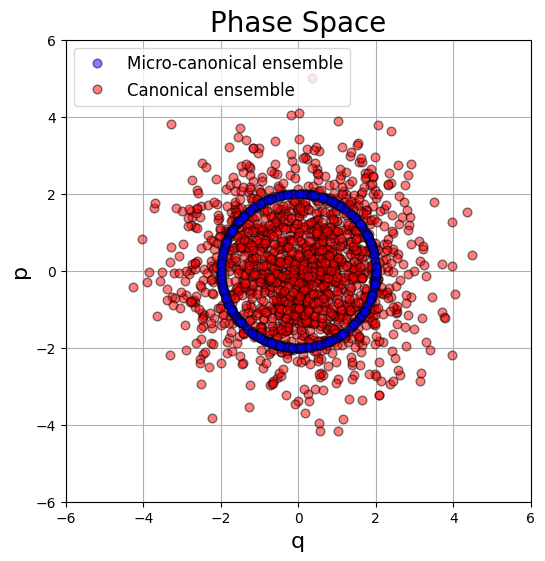

In [16]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig,ax = plt.subplots(figsize=(6,6))

def animate(i):
    ax.clear()
    ax.set_xlim(-6.0, 6.0)
    ax.set_ylim(-6.0, 6.0)
    ax.set_title('Phase Space', fontsize=20)
    ax.grid(True)
    points, oscillator_index = [], num_oscilators-2
    
    point, = ax.plot(qs[0][i] , ps[0][i], marker=".", alpha=0.5, color='blue', linewidth =1.5, markeredgecolor='black', markersize=12.5, label = r'Micro-canonical ensemble', linestyle="None")
    points.append(point,)
    point, = ax.plot(qs[-1][i], ps[-1][i], marker=".", alpha=0.5, color='red', linewidth =1.5, markeredgecolor='black', markersize=12.5, label = r'Canonical ensemble', linestyle="None")
    points.append(point,)
    
    for q, p in zip(qs[1:-1][::-1], ps[1:-1][::-1]):
        
        if oscillator_index < num_oscilators//5:
            point, = ax.plot(q[i], p[i], marker=".", alpha=0.5, color='blue', linewidth =1.5, markeredgecolor='black', markersize=12.5)
        else:
            point, = ax.plot(q[i], p[i], marker=".", alpha=0.5, color='red' , linewidth =1.5, markeredgecolor='black', markersize=12.5)
        points.append(point,)
        oscillator_index -= 1
        
    ax.set_xlabel('q', fontsize=16)
    ax.set_ylabel('p', fontsize=16)
    ax.legend(loc='upper left', fontsize='large')
    return tuple(points)

ani = FuncAnimation(fig, animate, interval=50, blit=True, repeat=True, frames=150)  
  
ani.save("ensembles.gif", dpi=100, writer=PillowWriter(fps=20))